In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.fftpack import rfft, irfft, fftfreq
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Rain data obtained from Rutgers Meterological Station https://www.njweather.org/data/5min/1101

In [4]:
#Setting up some variables to make the next few sections easier
rgd     = pd.read_csv('./rgdata.csv')
#Below is the setup for different sections of data to be able to zoom in
# on the filters later.
t0=rgd['Time since start (minutes)']  #full time of data collection for overall trend
time1start=0
time1end=19647 #1 week of data collection to see trends from day to day
t1=rgd['Time since start (minutes)'].iloc[time1start:time1end]
time2start=4506
time2end=7367 #1 full day/night cycle to see trends from hour to hour
t2=rgd['Time since start (minutes)'].iloc[time2start:time2end]

C:\Users\cassi_000\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
#To get low pass and high pass signals 
windowSize=3*120 #3 h

dataptToShow = 'Soil Moisture Sensor 1 (cap)'
originalSignal = rgd[dataptToShow] #entire data set
sms1_lowpass = originalSignal.rolling(windowSize, center=True).mean()
sms1_highpass = originalSignal - sms1_lowpass 

dataptToShow = 'Soil Moisture Sensor 2 (cap)'
originalSignal = rgd[dataptToShow] #entire data set
sms2_lowpass = originalSignal.rolling(windowSize, center=True).mean()
sms2_highpass = originalSignal - sms2_lowpass 

dataptToShow = 'Soil Moisture Sensor 3 (cap)'
originalSignal = rgd[dataptToShow] #entire data set
sms3_lowpass = originalSignal.rolling(windowSize, center=True).mean()
sms3_highpass = originalSignal - sms3_lowpass

dataptToShow = 'Temperature (deg C)'
originalSignal = rgd[dataptToShow] #entire data set
temp_lowpass = originalSignal.rolling(windowSize, center=True).mean()
temp_highpass = originalSignal - temp_lowpass

dataptToShow = 'Humidity (%)'
originalSignal = rgd[dataptToShow] #entire data set
rh_lowpass = originalSignal.rolling(windowSize, center=True).mean()
rh_highpass = originalSignal - rh_lowpass

In [13]:
#Here we make a new data set with just the low pass filtered data. This way
#our regressions will not be ruined by data abberrations
lpfilteredRGD=pd.DataFrame({'Time since start (minutes)': t0,
                            'Low Pass Temperature (deg C)': temp_lowpass,
                            'Low Pass Relative Humidity (%)': rh_lowpass,
                            'Low Pass Soil Moisture S1 (cap)': sms1_lowpass,
                            'Low Pass Soil Moisture S2 (cap)': sms2_lowpass,
                            'Low Pass Soil Moisture S3 (cap)': sms3_lowpass,
                            'Rain (inch)': rgd['Inches of rain']})
hpfilteredRGD=pd.DataFrame({'Time since start (minutes)': t0,
                            'High Pass Temperature (deg C)': temp_highpass,
                            'High Pass Relative Humidity (%)': rh_highpass,
                            'High Pass Soil Moisture S1 (cap)': sms1_highpass,
                            'High Pass Soil Moisture S2 (cap)': sms2_highpass,
                            'High Pass Soil Moisture S3 (cap)': sms3_highpass})
#Drop the na values
lpfilteredRGD=lpfilteredRGD.dropna()
hpfilteredRGD=hpfilteredRGD.dropna()

temp_lhRGD=pd.DataFrame({'Low Pass Temperature (deg C)': temp_lowpass, 'High Pass Temperature (deg C)': temp_highpass}).dropna().corr()
rh_lhRGD=pd.DataFrame({'Low Pass Relative Humidity (%)': rh_lowpass,'High Pass Relative Humidity (%)': rh_highpass}).dropna().corr()
sms1_lhRGD=pd.DataFrame({'Low Pass Soil Moisture S1 (cap)': sms1_lowpass,'High Pass Soil Moisture S1 (cap)': sms1_highpass}).dropna().corr()
sms2_lhRGD=pd.DataFrame({'Low Pass Soil Moisture S2 (cap)': sms2_lowpass,'High Pass Soil Moisture S2 (cap)': sms2_highpass}).dropna().corr()
sms3_lhRGD=pd.DataFrame({'Low Pass Soil Moisture S3 (cap)': sms3_lowpass,'High Pass Soil Moisture S3 (cap)': sms3_highpass}).dropna().corr()

#Correlate
print(temp_lhRGD, 
      rh_lhRGD, 
      sms1_lhRGD, 
      sms2_lhRGD, 
      sms3_lhRGD)


#The high and low frequency signals do not seem to correlate with one another. This, however, does not make sense, as 
#the high frequency signal is generated from the low frequency signal. Perhaps our window size is sufficiently large
#to reduce this correlation.

                               Low Pass Temperature (deg C)  \
Low Pass Temperature (deg C)                       1.000000   
High Pass Temperature (deg C)                      0.140551   

                               High Pass Temperature (deg C)  
Low Pass Temperature (deg C)                        0.140551  
High Pass Temperature (deg C)                       1.000000                                    Low Pass Relative Humidity (%)  \
Low Pass Relative Humidity (%)                         1.000000   
High Pass Relative Humidity (%)                        0.053458   

                                 High Pass Relative Humidity (%)  
Low Pass Relative Humidity (%)                          0.053458  
High Pass Relative Humidity (%)                         1.000000                                     Low Pass Soil Moisture S1 (cap)  \
Low Pass Soil Moisture S1 (cap)                          1.000000   
High Pass Soil Moisture S1 (cap)                         0.060632   

          

In [14]:
#Conversion from capacitance readings to volume of water. Assumed linear calibration curve
#Sensor 1
Sat_cap1=680 #taken from field calibration data
Dry_cap1=282
m1=(100-0)/(Sat_cap1-Dry_cap1)
b1=-m1*Dry_cap1
#Sensor 2
Sat_cap2=874 #taken from field calibration data
Dry_cap2=218
m2=(100-0)/(Sat_cap2-Dry_cap2)
b2=-m2*Dry_cap2
#Sensor 3               
Sat_cap3=1012 #taken from field calibration data
Dry_cap3=264
m3=(100-0)/(Sat_cap3-Dry_cap3)
b3=-m3*Dry_cap3

percentwater1=m1*lpfilteredRGD['Low Pass Soil Moisture S1 (cap)']+b1 #calibration curve generated from experiment
percentwater2=m2*lpfilteredRGD['Low Pass Soil Moisture S2 (cap)']+b2 #calibration curve generated from experiment
percentwater3=m3*lpfilteredRGD['Low Pass Soil Moisture S3 (cap)']+b3 #calibration curve generated from experiment

#calculates percent of void spaces full of water from capacitance readings
A_basin=1.17*4046.86 #meters
sensor_length=2.75*0.0254 #meters
vol_soil=A_basin*sensor_length #meters cubed
porosity=0.25 #http://www.leesburgva.gov/home/showdocument?id=5057

waterVol1=percentwater1*vol_soil*porosity #volume water in top few inches of basin
waterVol2=percentwater2*vol_soil*porosity #volume water in top few inches of basin
waterVol3=percentwater3*vol_soil*porosity #volume water in top few inches of basin
waterVolavg=(waterVol1+waterVol2)/2 #volume water in top few inches of basin

freezept=0
timefreezing=lpfilteredRGD['Time since start (minutes)'].loc[lpfilteredRGD['Low Pass Temperature (deg C)']<freezept]
timenotfreezing=lpfilteredRGD['Time since start (minutes)'].loc[lpfilteredRGD['Low Pass Temperature (deg C)']>=freezept]
freezing1=waterVol1.loc[lpfilteredRGD['Low Pass Temperature (deg C)']<freezept]
notfreezing1=waterVol1.loc[lpfilteredRGD['Low Pass Temperature (deg C)']>=freezept]
freezing2=waterVol2.loc[lpfilteredRGD['Low Pass Temperature (deg C)']<freezept]
notfreezing2=waterVol2.loc[lpfilteredRGD['Low Pass Temperature (deg C)']>=freezept]
freezing3=waterVol3.loc[lpfilteredRGD['Low Pass Temperature (deg C)']<freezept]
notfreezing3=waterVol3.loc[lpfilteredRGD['Low Pass Temperature (deg C)']>=freezept]
freezingavg=waterVolavg.loc[lpfilteredRGD['Low Pass Temperature (deg C)']<freezept]
notfreezingavg=waterVolavg.loc[lpfilteredRGD['Low Pass Temperature (deg C)']>=freezept]

In [15]:
#Conceptual Model
#d(Volume water in top few inches of soil)/d(time)=d(Volume water in from rain&runoff)/dt-d(Volume of water that drains from the basin)/dt-Evaporation
#Certain parameters of evaporation must be locally calibrated. We will do this in the next section.

In [16]:
#Water Volume in                    Altered time of concentration (timeDelay)- dictates time for runoff to reach basin

#Rain
vol_rain=A_basin*lpfilteredRGD['Rain (inch)']*0.0254 #0.5 min time step, m3/0.5 min
#Runoff with delay due to drainage
v_runoff=(2.03*.89+1.47*.91)*4046.86*lpfilteredRGD['Rain (inch)']
timeDelay=240 #minutes
v_runoff.index=v_runoff.index+timeDelay*2
vol_runoff=np.zeros((timeDelay*2,1))
a=pd.DataFrame(vol_rain).first_valid_index()
b=pd.DataFrame(vol_rain).first_valid_index()+2*timeDelay-1
c=b-a
index_labels=np.linspace(start=a,stop=b, num=c+1)
vol_runoff=pd.Series({'Rain (inch)':[vol_runoff]}).reindex(index=index_labels).fillna(0).append(v_runoff)
d=pd.Series(vol_rain).last_valid_index()
vol_runoff=vol_runoff.loc[:d]

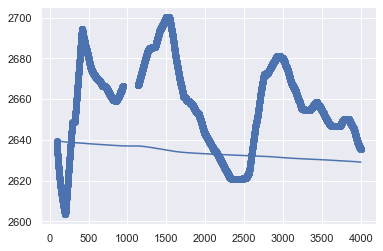

In [22]:
#Evaporation equation/Calibration     Calibrated evaporation coefficient during a time of no rain
timeevap=lpfilteredRGD['Time since start (minutes)'].loc(axis=0)[:7500]
temp=lpfilteredRGD['Low Pass Temperature (deg C)'].loc(axis=0)[:7500]
humid=lpfilteredRGD['Low Pass Relative Humidity (%)'].loc(axis=0)[:7500]

SVP=610.7*(10**((7.5*temp)/(temp+237.3)))
VPD=(1-(humid/100))*SVP/1000 #http://cronklab.wikidot.com/calculation-of-vapour-pressure-deficit
evap_constant=[10] #tried 1, 10, 100
evap=((VPD*evap_constant)*A_basin/1000)/(60*2*24) #meters cubed/0.5 min https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2014WR015523

#For loop to get iterative changes
deltaV=-evap #change in volume/0.5 min
deltat=0.5 #1/2 minute time step
initial=waterVol2.iloc[0]
timeindex=lpfilteredRGD['Time since start (minutes)'].index #There are time jumps due to low pass filtering so we need to account for those in our model

#To generate model data from iterative changes
waterVol_model=np.zeros((len(deltaV),len(evap_constant)))
waterVol_model[0]=initial+deltaV.iloc[0]*deltat
for n in range(1,len(deltaV)):
        waterVol_model[n]=waterVol_model[n-1]+deltaV.iloc[n]*deltat*(timeindex[n]-timeindex[n-1]) #multiply delta t by step in index

x=timeevap
waterVol2plot=waterVol2.loc(axis=0)[:7500]
plt.scatter(x, waterVol2plot)
plt.plot(x, waterVol_model)
#Comparing measured water volume during a period of no rain to the model.
#Guessing and checking to find the optimal evaporation coefficient.

bestevapconstant=10
#Calibrated evaporation
temp=lpfilteredRGD['Low Pass Temperature (deg C)']
humid=lpfilteredRGD['Low Pass Relative Humidity (%)']
SVP=610.7*(10**((7.5*temp)/(temp+237.3)))
VPD=(1-(humid/100))*SVP/1000 #http://cronklab.wikidot.com/calculation-of-vapour-pressure-deficit
evap_constant=bestevapconstant 
evap=((VPD*evap_constant)*A_basin/1000)/(60*2*24) #meters cubed/0.5 min https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2014WR015523

Max water volume (m3): 
8268.190251749998


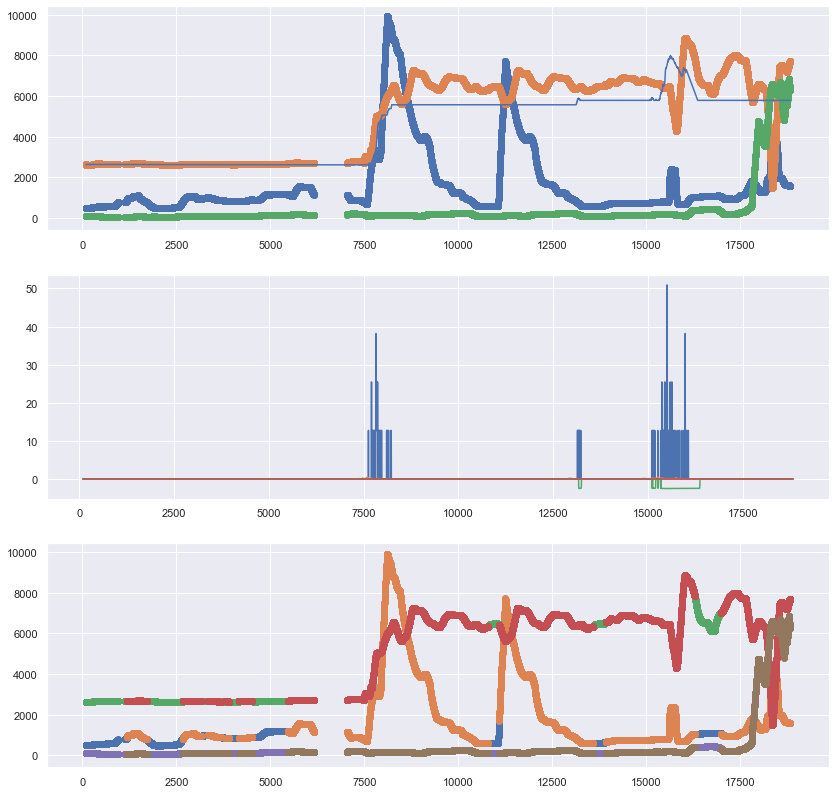

In [19]:
#Model/Drainage Calibration        Altered Saturated Hydraulic Conductivity (Ksi) and Field Capacity (FC)
import math

maxwaterVol=100*vol_soil*porosity
print('Max water volume (m3): ')
print(maxwaterVol)

#Drainage https://www.ars.usda.gov/ARSUserFiles/50201000/WEPP/chap5.pdf
FC=maxwaterVol*.7/(A_basin) 
Ksi=2.5*0.0254/(60*60) #m/s   2.75 inch/h
#won't drain below a certain point-- if theta > fc, then drain

#For loop to get iterative changes
deltaV=-evap+vol_rain+vol_runoff #change in volume/0.5 min
deltat=0.5 #1/2 minute time step
initial=waterVol2.iloc[0]

timeindex=lpfilteredRGD['Time since start (minutes)'].index #There are time jumps due to low pass filtering so we need to account for those in our model

#To generate model data from iterative changes
waterVol_model=np.zeros((len(deltaV),1))
vol_drainage=np.zeros((len(deltaV),1))
drainage=np.zeros((len(deltaV),1))
theta=np.zeros((len(deltaV),1))
UL=np.zeros((len(deltaV),1))
waterVol_model[0]=initial+deltaV.iloc[0]*deltat
theta[0]=waterVol_model[0]/A_basin
UL[0]=theta[0]
for n in range(1,len(deltaV)):
    if theta[n-1]>FC:
        drainage[n]=((theta[n-1]-FC)*(1-math.exp(-(deltat*60*(timeindex[n]-timeindex[n-1]))/((theta[n-1]-FC)/(Ksi*(theta[n-1]/(UL[n-1]))**(-2.655/(math.log(FC/UL[n-1]))))))))*A_basin
        waterVol_model[n]=waterVol_model[n-1]+deltaV.iloc[n]*deltat*(timeindex[n]-timeindex[n-1])-drainage[n]
        theta[n]=waterVol_model[n]/(A_basin)
        UL[n]=theta[n]
    else:
        waterVol_model[n]=waterVol_model[n-1]+deltaV.iloc[n]*deltat*(timeindex[n]-timeindex[n-1])
        theta[n]=waterVol_model[n]/(A_basin)
        UL[n]=theta[n]       
        drainage[n]=0

evaporation=-evap
vol_drainage=-drainage

time=lpfilteredRGD['Time since start (minutes)']
x=time

#Decided that sensor 2 is the only one that has good data. Sensor 3 never changes, and sensor 1 has strange variations in the middle
# of its data set that do not correspond to rainfall
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(14,14))
#Plots the model against the water volume measured by the sensor. Sensors 1 and 3 are omitted
#for clarity.
#ax[0].scatter(x, waterVol1)
ax[0].scatter(x, waterVol2)
#ax[0].scatter(x, waterVol3)
ax[0].plot(x, waterVol_model)

#Plots each of the terms of the model equation individually to show their
#respective contributions to the changes observed in the model.
ax[1].plot(x, vol_runoff)
ax[1].plot(x, vol_rain)
ax[1].plot(x, vol_drainage)
ax[1].plot(x, evaporation)

#Plots the time at which the air temperature was at or below freezing separately from
#when it was above freezing. This is an attempt to ascertain a possible reason
#behind nonsensical sensor data fluctuations. Freeze/thaw does not seem to affect
#readings significantly.
ax[2].scatter(timefreezing, freezing1)
ax[2].scatter(timenotfreezing, notfreezing1)
ax[2].scatter(timefreezing, freezing2)
ax[2].scatter(timenotfreezing, notfreezing2)
ax[2].scatter(timefreezing, freezing3)
ax[2].scatter(timenotfreezing, notfreezing3)

to do
-format info for upload
-look at percolation equation and evaporation
-decide on raw data trends raw/lp sensor/temp/humidity data
-decide on modeling results and how you will present them
-why does this matter
-what have others done?
-decide on objectives
-decide on how to throw out sensor data